In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import math

kaggle_api_key_path = ''
if os.getlogin() != 'wtaranto':
    from google.colab import drive
    drive.mount("/content/gdrive")
    with open(keypath, 'r') as f:
        envs = json.load(f)
    os.environ["KAGGLE_USERNAME"] = envs['username']
    os.environ["KAGGLE_KEY"] = envs['key']

# Download 
!kaggle datasets download -d jainaru/world-happiness-report-2024-yearly-updated 
!unzip world-happiness-report-2024-yearly-updated.zip

Dataset URL: https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated
License(s): CC0-1.0
world-happiness-report-2024-yearly-updated.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  world-happiness-report-2024-yearly-updated.zip
  inflating: World-happiness-report-2024.csv  
  inflating: World-happiness-report-updated_2024.csv  


In [2]:
raw_data = pd.read_csv('World-happiness-report-2024.csv')
raw_data.head()

,Country name,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298


In [3]:
rename_dict = {
    'Country name'                 : 'country',
    'regional indicator'           : 'region',
    'Ladder score'                 : 'happiness',
    'upperwhisker'                 : 'uwhisk',
    'lowerwhisker'                 : 'lwhisk',
    'Log GDP per capita'           : 'logGDPPC',
    'Social support'               : 'family',
    'Healthy life expectancy'      : 'health',
    'Freedom to make life choices' : 'freedom',
    'Generosity'                   : 'generosity',
    'Perceptions of corruption'    : 'corruption',
    'Dystopia + residual'          : 'dystopia'
}
raw_data = raw_data.rename(columns=rename_dict)
print(raw_data.isna().sum().sum())
raw_data = raw_data.dropna()

21


In [4]:
cols = raw_data.columns.tolist()
numerical_cols = [cols[2]] + cols[5:] # I'm excluding the uncertainty whiskers from the learning

mm_data = raw_data.copy()
for col in numerical_cols:
    mm_data[col] = (raw_data[col] - raw_data[col].min()) / (raw_data[col].max() - raw_data[col].min())
std_data = raw_data.copy()
for col in numerical_cols:
    std_data[col] = (raw_data[col] - raw_data[col].mean()) / raw_data[col].std()

mm_data.head()

,country,Regional indicator,happiness,uwhisk,lwhisk,logGDPPC,family,health,freedom,generosity,corruption,dystopia
0,Finland,Western Europe,1.000000,7.815,7.667,0.861280,0.972171,0.810968,0.995365,0.354115,0.949565,0.701726
1,Denmark,Western Europe,0.973754,7.665,7.500,0.891172,0.940012,0.815636,0.953650,0.508728,0.953043,0.636275
2,Iceland,Western Europe,0.964120,7.618,7.433,0.878561,1.000000,0.837806,0.949015,0.643392,0.316522,0.691306
3,Sweden,Western Europe,0.934053,7.422,7.267,0.877160,0.928262,0.844807,0.971031,0.551122,0.911304,0.563660
4,Israel,Middle East and North Africa,0.933555,7.405,7.277,0.842130,0.935683,0.863477,0.742758,0.381546,0.335652,0.772061


In [5]:
std_data.describe()

,happiness,uwhisk,lwhisk,logGDPPC,family,health,freedom,generosity,corruption,dystopia
count,1.400000e+02,140.000000,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02
mean,-5.075305e-16,5.644057,5.417700,-1.015061e-16,1.015061e-16,-5.075305e-17,1.015061e-16,-1.268826e-16,2.030122e-16,-2.030122e-16
std,1.000000e+00,1.165108,1.198051,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.225315e+00,1.775000,1.667000,-3.243502e+00,-3.403151e+00,-3.158366e+00,-3.819401e+00,-1.991678e+00,-1.220878e+00,-3.067984e+00
25%,-7.611812e-01,4.762250,4.503750,-7.082059e-01,-6.377667e-01,-7.451118e-01,-5.730838e-01,-7.525933e-01,-6.762726e-01,-4.980185e-01
50%,2.282395e-01,5.911000,5.676500,1.239545e-01,3.095293e-01,1.735014e-01,1.254129e-01,-1.330509e-01,-2.663333e-01,1.276112e-01
75%,7.579763e-01,6.515250,6.338250,8.531976e-01,7.468006e-01,7.737832e-01,7.100577e-01,6.294629e-01,3.139191e-01,5.690406e-01
max,1.870995e+00,7.815000,7.667000,1.792980e+00,1.448085e+00,2.038013e+00,1.491636e+00,3.468465e+00,3.334004e+00,2.645945e+00


In [6]:
mm_data.describe()

,happiness,uwhisk,lwhisk,logGDPPC,family,health,freedom,generosity,corruption,dystopia
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.632873,5.644057,5.417700,0.644001,0.701502,0.607801,0.719144,0.364767,0.268037,0.536931
std,0.196220,1.165108,1.198051,0.198551,0.206133,0.192442,0.188287,0.183145,0.219545,0.175011
min,0.000000,1.775000,1.667000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.483513,4.762250,4.503750,0.503386,0.570037,0.464411,0.611240,0.226933,0.119565,0.449772
50%,0.677658,5.911000,5.676500,0.668613,0.765306,0.641190,0.742758,0.340399,0.209565,0.559264
75%,0.781603,6.515250,6.338250,0.813405,0.855442,0.756709,0.852839,0.480050,0.336957,0.636519
max,1.000000,7.815000,7.667000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0.98, 'Standardized Data - Scatter Matrix')

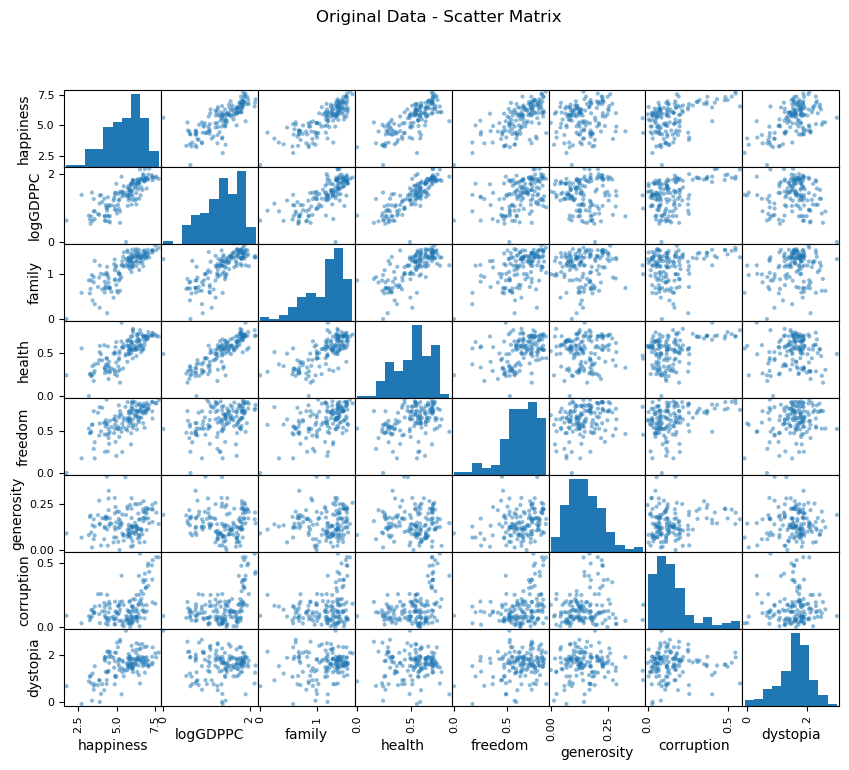

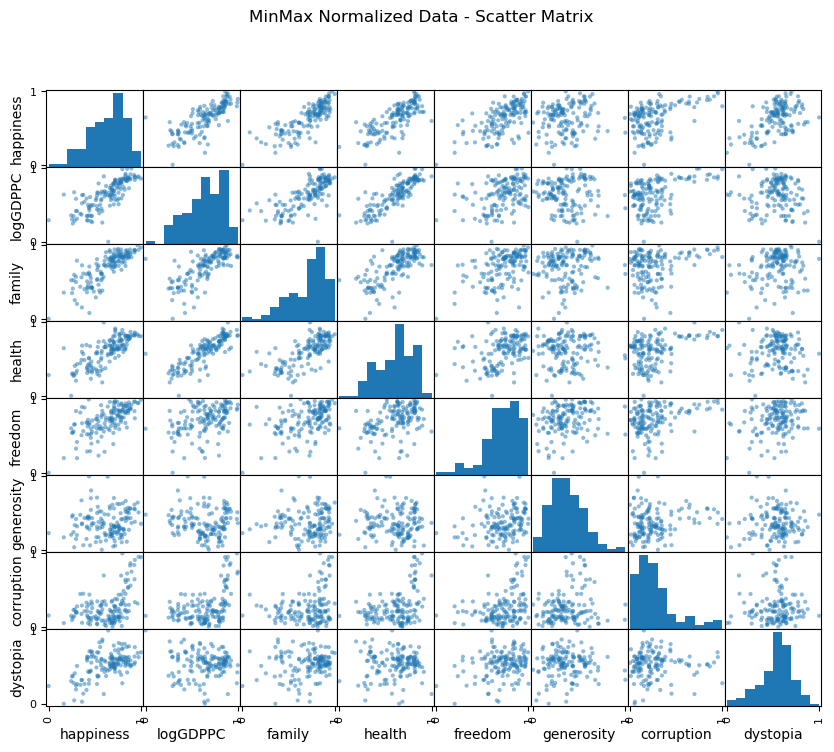

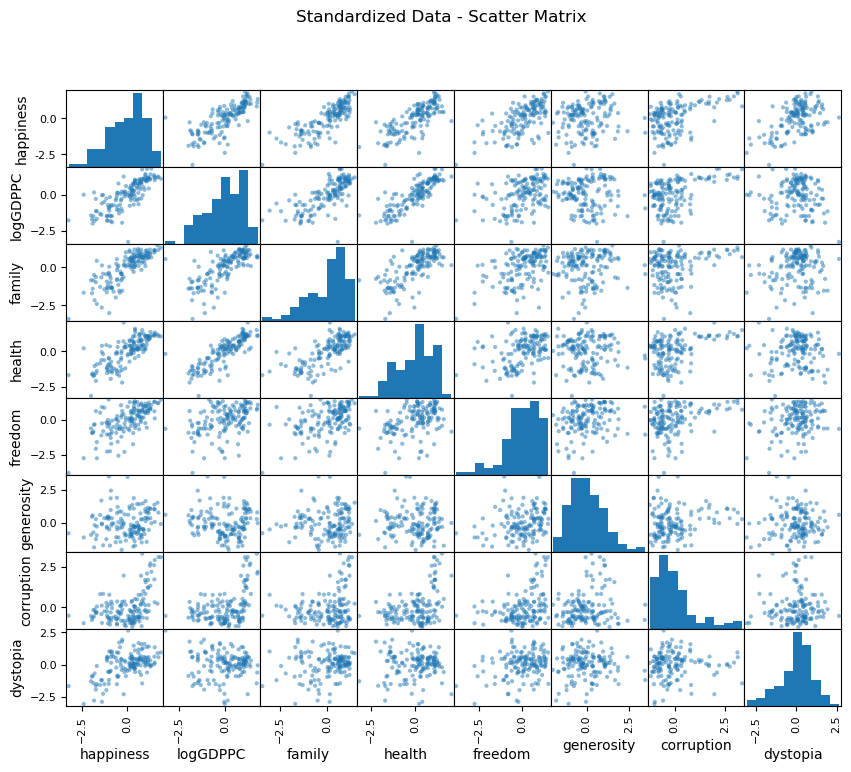

In [7]:
# Create scatter matrix for original data
pd.plotting.scatter_matrix(raw_data[numerical_cols], figsize=(10,8))
plt.suptitle('Original Data - Scatter Matrix')

# Create scatter matrix for minmax normalized data
pd.plotting.scatter_matrix(mm_data[numerical_cols], figsize=(10,8))
plt.suptitle('MinMax Normalized Data - Scatter Matrix')

# Create scatter matrix for standardized data
pd.plotting.scatter_matrix(std_data[numerical_cols], figsize=(10,8))
plt.suptitle('Standardized Data - Scatter Matrix')

Captions: Histograms and Scatter plots from the world happiness report in 2024. The plots form a matrix of all permutations (with replacement) between different measured quantities (descriptions of the quntities can be found at https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated). Each of the three plots are scaled with a different scheme: no-scale, min-max scaling, and standard scaling. The diagonal entries of these plots are histograms of the quantity. For the off-diagonal elements, a small scatter plot of the quantity on the horizontal axis vs the quantity on the vertical axis is shown. The first four quantities, health, family, logGDPPC, and happiness, show highest correlation with each pointing to some underlying mechnism linking them. I suspect this mechanism is actually just gdp per capita. If so, the logGDPPC versus happiness plots display the marginal utility of wealth (if the happiness metric uses a linear unit): increase in happiness is takes more money the more happy you are.

In [8]:
from sklearn.cluster import KMeans

features = ['family', 'health', 'freedom', 'corruption', 'generosity', 'dystopia']

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(mm_data[features])

mm_data['cluster'] = clusters
mm_data

,country,Regional indicator,happiness,uwhisk,lwhisk,logGDPPC,family,health,freedom,generosity,corruption,dystopia,cluster
0,Finland,Western Europe,1.000000,7.815,7.667,0.861280,0.972171,0.810968,0.995365,0.354115,0.949565,0.701726,2
1,Denmark,Western Europe,0.973754,7.665,7.500,0.891172,0.940012,0.815636,0.953650,0.508728,0.953043,0.636275,2
2,Iceland,Western Europe,0.964120,7.618,7.433,0.878561,1.000000,0.837806,0.949015,0.643392,0.316522,0.691306,2
3,Sweden,Western Europe,0.934053,7.422,7.267,0.877160,0.928262,0.844807,0.971031,0.551122,0.911304,0.563660,2
4,Israel,Middle East and North Africa,0.933555,7.405,7.277,0.842130,0.935683,0.863477,0.742758,0.381546,0.335652,0.772061,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Congo (Kinshasa),Sub-Saharan Africa,0.261462,3.462,3.128,0.249416,0.411255,0.305718,0.548088,0.471322,0.125217,0.382612,1
139,Sierra Leone,Sub-Saharan Africa,0.253156,3.366,3.124,0.305465,0.350031,0.295216,0.543453,0.451372,0.092174,0.371540,1
140,Lesotho,Sub-Saharan Africa,0.243355,3.469,2.904,0.360112,0.526283,0.000000,0.606025,0.204489,0.147826,0.308694,1
141,Lebanon,Middle East and North Africa,0.163787,2.797,2.616,0.643157,0.356834,0.648775,0.200463,0.169576,0.050435,0.000000,1


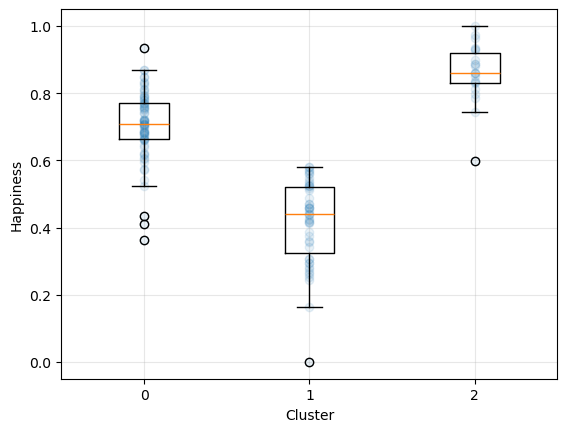

In [9]:


plt.scatter(mm_data['cluster'], mm_data['happiness'], alpha=0.1, marker='o')

cluster_happiness = [mm_data[mm_data['cluster'] == i]['happiness'] for i in range(3)]


plt.boxplot(cluster_happiness, positions=range(3))
plt.xlabel('Cluster')
plt.ylabel('Happiness')
plt.ylim([-0.05,1.05])
plt.grid(True, alpha=0.3)
plt.show()

Caption: A box and whisker plot of happiness versus cluster assignment. The whiskers are the range of non-outlier data with the box containing the iterquartile data, and the central line is the median. Ouliers are defined as data which lie outside of 1.5 times the interquartile range. The different clusters on the horizontal axis were determined from a k-means algorithm with three clusters. The data fields input into the k-means algorithm were family, health, freedom, corruption, generosity, and dystopia. Cluster 1 has multiple dense regions, one around the median and two outside the interquartile range. This suggests that there should possibly be 5 clusters instead of 3 to account for these other density peaks. 

/tmp/ipykernel_38996/2915008436.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mm_data[cluster_name] = clusters
/tmp/ipykernel_38996/2915008436.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mm_data[cluster_name] = clusters
/tmp/ipykernel_38996/2915008436.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

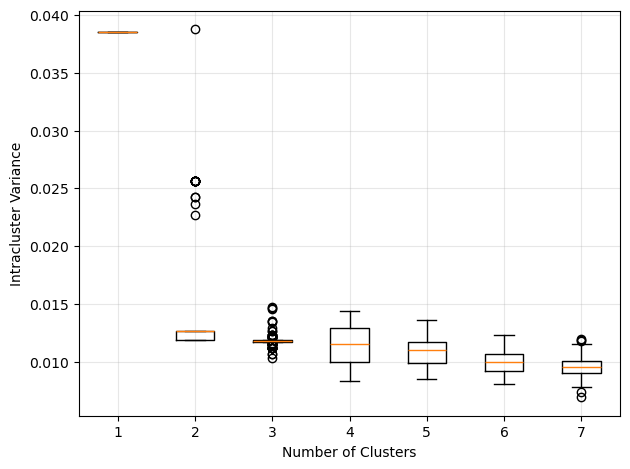

In [10]:
seed_num = 100
cluster_num = [1, 2, 3, 4, 5, 6, 7] # I added 1 cluster because I was curious

variances = []
for seed in range(seed_num):
    variances.append([])
    for k in cluster_num:
        # KMeans
        cluster_name = f'cluster,{k},{seed}'
        kmeans = KMeans(n_clusters=k, random_state=seed)
        clusters = kmeans.fit_predict(mm_data[features])
        mm_data[cluster_name] = clusters
        
        # Variance Calc
        tot_variance = 0
        for i in range(k):
            cluster_data = mm_data[mm_data[cluster_name] == i]['happiness']
            cluster_variance = cluster_data.var()
            if math.isnan(cluster_variance):
                cluster_variance = 0
            tot_variance += cluster_variance * len(cluster_data)
        
        # average variance over cluster
        tot_variance /= len(mm_data)
        variances[seed].append(tot_variance)

variance_array = np.array(variances)
plt.boxplot(variance_array, positions=np.array(cluster_num))


plt.xlabel('Number of Clusters')
plt.ylabel('Intracluster Variance')
plt.grid(True, alpha=0.3)
plt.xticks(cluster_num)
plt.tight_layout()
plt.show()


Caption: An inertia elbow plot for an ensemble of 100 clusterings performed by kmeans with 1 to 7 clusters as a hyperparameter. The horizontal axis is cluster number provided to the kmeans algorithm, and the vertical axis is the total intracluster variance. The box plots contain 100 variances corresponding to kmeans being run with different seeds. The median value of the ensembles doesn't change significantly by increase after 2 clusters. This would suggest that 2 clusters is a good choice, but 3 clusters has a very dense median which the entire interquartile range converged to. Either 2 or 3 clusters have merit, but beyond 3 the interquartile range increases with diminishing returns.